# Multi-Label Multi-Class Image Classification

This problem is being framed as ***Transfer Learning*** problem. A ***ResNet-50*** backbone is being used and on top of it a custom model is developed which can predict ***Neck***, ***Sleeve Length*** and ***Pattern*** using a ***single*** neural network model. 

In [39]:
# Importing the necessary libraries 
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Exploratory Data Analysis

In [40]:
# loading the attributes in memory
attributes_df = pd.read_csv("attributes.csv")
attributes_df.head()

,filename,neck,sleeve_length,pattern
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,6.0,NaN,4.0
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,5.0,3.0,9.0
2,11479107741104-Tommy-Hilfiger-Men-Navy-Blue-St...,6.0,1.0,9.0
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,NaN,0.0,9.0
4,11516770810185-Splash-Men-Tshirts-767151677081...,6.0,3.0,9.0


In [41]:
# determining the number of classes apart from NaN present in each label (# of Classes in neck, sleeve_length, pattern)
print("The number of classes in neck : " + str(attributes_df["neck"].max()))
print("The number of classes in neck : " + str(attributes_df["sleeve_length"].max()))
print("The number of classes in neck : " + str(attributes_df["pattern"].max()))

The number of classes in neck : 6.0
The number of classes in neck : 3.0
The number of classes in neck : 9.0


In [42]:
# Making the NaN data in each label as the N+1 class by imputing
attributes_df["neck"] = attributes_df["neck"].fillna(7.0)
attributes_df["sleeve_length"] = attributes_df["sleeve_length"].fillna(4.0)
attributes_df["pattern"] = attributes_df["pattern"].fillna(10.0)

In [43]:
# Check for NaN value after imputing (The NaN should be converted into it's own class in the last step)
print(attributes_df.isna().sum())

filename         0
neck             0
sleeve_length    0
pattern          0
dtype: int64


In [44]:
# Applying Lamba function on columns to convert the labels from float to int
attributes_df["neck"] = attributes_df["neck"].apply(lambda x: int(x))
attributes_df["sleeve_length"] = attributes_df["sleeve_length"].apply(lambda x: int(x))
attributes_df["pattern"] = attributes_df["pattern"].apply(lambda x: int(x))

In [45]:
# Visually verifying the lambda operation
attributes_df.head()

,filename,neck,sleeve_length,pattern
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,6,4,4
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,5,3,9
2,11479107741104-Tommy-Hilfiger-Men-Navy-Blue-St...,6,1,9
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,7,0,9
4,11516770810185-Splash-Men-Tshirts-767151677081...,6,3,9


   neck_type  percentage_occurence
0          6             45.397676
1          7             20.330652
2          1              6.076854
3          4              5.987489
4          2              5.898123
5          0              5.585344
6          5              5.585344
7          3              5.138517


<AxesSubplot:xlabel='neck_type'>

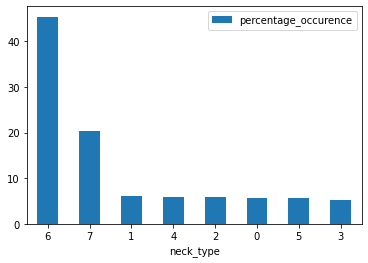

In [46]:
# Visualizing the distribution of "neck" label
neck_counts = attributes_df["neck"].value_counts(normalize=True).reset_index()
neck_counts = neck_counts.rename(columns = {"index": "neck_type","neck": "percentage_occurence"})
neck_counts["percentage_occurence"] = neck_counts["percentage_occurence"].apply(lambda x: x*100) 
print(neck_counts)
neck_counts.plot.bar(x="neck_type", rot=0)

   sleeve_type  percentage_occurence
0            3             61.170688
1            4             20.196604
2            2              6.613047
3            1              6.255585
4            0              5.764075


<AxesSubplot:xlabel='sleeve_type'>

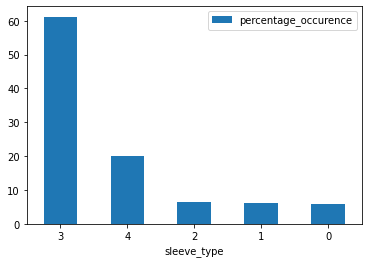

In [47]:
# Visualizing the distribution of "sleeve_length" label
sleeve_counts = attributes_df["sleeve_length"].value_counts(normalize=True).reset_index()
sleeve_counts = sleeve_counts.rename(columns = {"index": "sleeve_type","sleeve_length": "percentage_occurence"})
sleeve_counts["percentage_occurence"] = sleeve_counts["percentage_occurence"].apply(lambda x: x*100) 
print(sleeve_counts)
sleeve_counts.plot.bar(x="sleeve_type", rot=0)

    pattern_type  percentage_occurence
0              9             65.549598
1             10             19.973190
2              6              2.323503
3              3              2.055407
4              5              1.697945
5              4              1.653262
6              1              1.653262
7              8              1.429848
8              7              1.429848
9              2              1.295800
10             0              0.938338


<AxesSubplot:xlabel='pattern_type'>

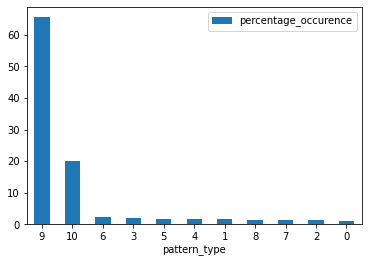

In [48]:
# Visualizing the distribution of "pattern" label
pattern_counts = attributes_df["pattern"].value_counts(normalize=True).reset_index()
pattern_counts = pattern_counts.rename(columns = {"index": "pattern_type","pattern": "percentage_occurence"})
pattern_counts["percentage_occurence"] = pattern_counts["percentage_occurence"].apply(lambda x: x*100) 
print(pattern_counts)
pattern_counts.plot.bar(x="pattern_type", rot=0)

# Takeaways from visualizing the label distributions

All the labels have severly imbalanced classes. The imbalance is the worst in the "pattern" label where pattern_type: 9 and pattern_type: NA make upto 85% of the data.

Strategies for handling imbalance in data:
1. Oversample the minority classes
2. Undersample the majority classes
3. Assign class_weights to the class in the training process

Discussing each method in details

1. Oversampling by taking an image instance and adding Gaussian blur, Unsharp Mask, using the RGB to create mutliple copies of the same image which is slightly different. But where this level of imbalance is there in the dataset, such image augmentation and oversampling will cause a huge overfitting and loss of generalization (Didn't have time to prove this point by doing experiment). Also, here oversampling will not yield desired result because we are modelling for the 3 labels together, For eg, if we oversample a minority class of neck, it can happen that it might lead to oversampling of a majority class of sleeve_length which can lead to imbalance in the other label.

2. Undersampling the majority class is the other alternative. Throwing away information we have is never a good idea but since we have to balance the classes for all the labels we have to consider undersampling. But since we are modelling for 3 labels together, undersampling majority class of neck can lead to undersampling of minority class of sleeve_length. This situation is as bad as the first solution

3. Assigning class_weights is also not an option as the different labels dont have the same number of class and the keras implementation of class weight doesn't take dict of dict or dict of list as an input.

So for this problem we have to continue with the modelling without handling the imbalance as only 1 neural network can be trained to solve the 3 classification problem at once.

# Image Preprocessing

In [49]:
# read the image files 
path = "./images_copy/"
files = os.listdir(path)
print(len(files))

1778


In [50]:
# collecting the images and it's respective target label in ordered form for training

# empty list to collect images
images = []
# empty target array of size (N,3) where N is the number of images and 3 for the three label types
# Observation: Less images than rows in the attributes.csv (# of images = 1778, # of rows in attributes.csv = 2238)
target = np.zeros((len(files),3),dtype='int')
count = 0
for file in files:
    # read the image from path
    image = cv2.imread(path+file)
    image = cv2.resize(image,dsize=(300,300))
    # image resized to have the size (300,300,3) to ensure compliance with Resnet-50 input
    image = image.reshape((image.shape[0],image.shape[1],3))
    images.append(image)
    # find corresponding labels for the image from attributes.csv
    temp_df = attributes_df[attributes_df["filename"] == file]
    # store the corresspoding labels at the same relative index as the image
    target[count,0] = temp_df["neck"].iloc[0]
    target[count,1] = temp_df["sleeve_length"].iloc[0]
    target[count,2] = temp_df["pattern"].iloc[0]
    count+=1

In [51]:
# Check the length of the list storing the stack of images
print(len(images))

1778


In [52]:
# Check the shape of the label numpy array to check if # of images = # label rows
print(target.shape)

(1778, 3)


In [53]:
# function to display image
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

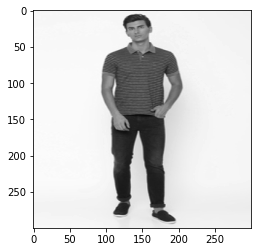

In [54]:
# Visually inspect a random image
display(images[550])

In [55]:
# Check the shape of the visually inspected image to ensure it matches the Resnet-50 input size
print(images[550].shape)

(300, 300, 3)


In [56]:
# Converting the stack of images to a numpy array
features = np.zeros((1778,300,300,3),dtype = 'float32')

for i in range(1778):
    features[i] = images[i]

# Assuming that the image is an 8-bit image we normalize the pixels of the image
features = features/255

In [57]:
print(type(features))
print(type(target))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [58]:
# train test split of the data and it's target
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 1422
Samples in Testing: 356


# Model Training

In [59]:
#  Loading the resnet-50 model as the pre-trained model trained on imagenet dataset
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (300, 300, 3))

In [60]:
# defining a function to generate configurable fully connected layers
def getFCLayers(num, size):
    return [size for i in range(num)]

In [61]:
# generating a single fully connected layer with 1024 nodes
fc_layers = getFCLayers(1, 1024)

In [62]:
# freezing the weights of the resnet-50 base model
for layer in base_model.layers:
    layer.trainable = False

In [63]:
 # building a custom layer for predicting neck type (Could only use 1 CNN-BN layer because of limited compute)
 model_neck = base_model.output   
 model_neck = Conv2D(2048, (3, 3), strides = (1, 1), padding = "valid")(model_neck)
 model_neck = BatchNormalization(axis = 3) (model_neck)
 model_neck = Activation('relu')(model_neck)

    # Flatten the output to pass to the FC layers
 model_neck = Flatten()(model_neck)

 for fc in fc_layers:
   # New FC layer, random init
   model_neck = Dense(fc, activation = 'relu')(model_neck) 

 model_neck = Dense(8, activation = 'softmax')(model_neck)  

In [64]:
 # building a custom layer for predicting neck type (Could only use 1 CNN-BN layer because of limited compute)
 model_sleeve = base_model.output   
 model_sleeve = Conv2D(2048, (3, 3), strides = (1, 1), padding = "valid")(model_sleeve)
 model_sleeve = BatchNormalization(axis = 3) (model_sleeve)
 model_sleeve = Activation('relu')(model_sleeve)

    # Flatten the output to pass to the FC layers
 model_sleeve = Flatten()(model_sleeve)

 for fc in fc_layers:
   # New FC layer, random init
   model_sleeve = Dense(fc, activation = 'relu')(model_sleeve) 

 model_sleeve = Dense(5, activation = 'softmax')(model_sleeve)  

In [65]:
 # building a custom layer for predicting neck type (Could only use 1 CNN-BN layer because of limited compute)
 model_pattern = base_model.output   
 model_pattern = Conv2D(2048, (3, 3), strides = (1, 1), padding = "valid")(model_pattern)
 model_pattern = BatchNormalization(axis = 3) (model_pattern)
 model_pattern = Activation('relu')(model_pattern)

 model_pattern = Flatten()(model_pattern)

 for fc in fc_layers:
   # New FC layer, random init
   model_pattern = Dense(fc, activation = 'relu')(model_pattern) 

 model_pattern = Dense(11, activation = 'softmax')(model_pattern)  

In [66]:
# Building a single Neural Network which makes prediction for all the 3 labels together 
model = Model(inputs=base_model.input, outputs=[model_neck,model_sleeve,model_pattern])
model.compile(optimizer = 'adam', loss =['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy'],metrics=['accuracy'])

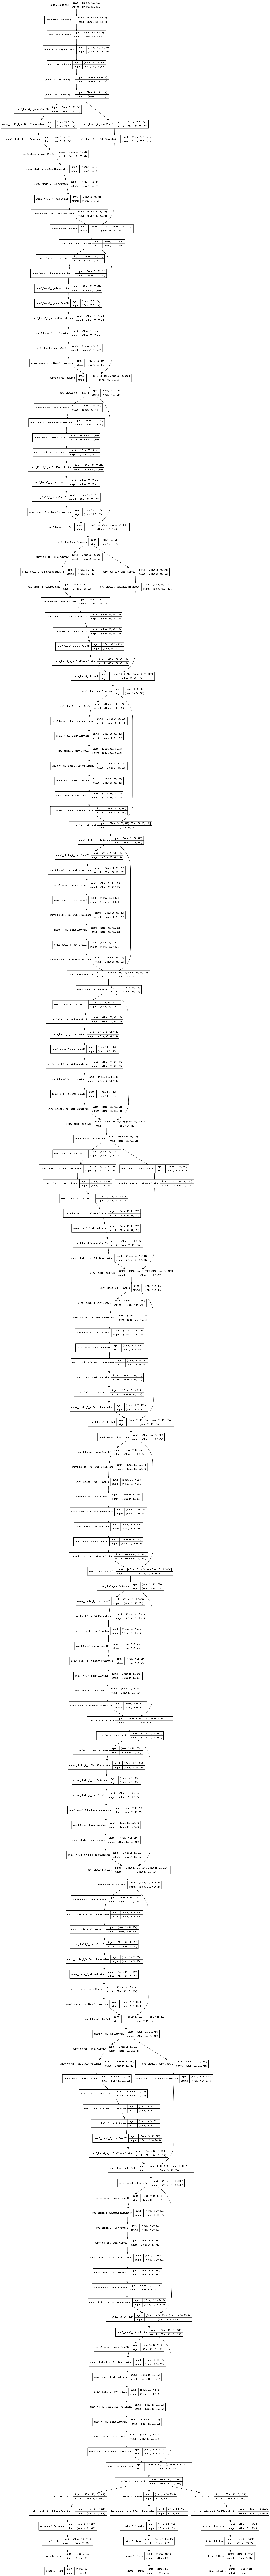

In [67]:
# Network Architecture of the model
dot_img_file = 'model.png'
tensorflow.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [68]:
# Training the model
h = model.fit(x_train,[y_train[:,0],y_train[:,1],y_train[:,2]],validation_data=(x_test,[y_test[:,0],y_test[:,1],y_test[:,2]]),epochs = 10, batch_size=128,shuffle = True)

Epoch 1/10
12/12 [==============================] - 709s 58s/step - loss: 308.5421 - dense_13_loss: 157.5609 - dense_15_loss: 68.0559 - dense_17_loss: 82.9253 - dense_13_accuracy: 0.2370 - dense_15_accuracy: 0.3094 - dense_17_accuracy: 0.3875 - val_loss: 696.1451 - val_dense_13_loss: 482.3463 - val_dense_15_loss: 49.9904 - val_dense_17_loss: 163.8084 - val_dense_13_accuracy: 0.0478 - val_dense_15_accuracy: 0.6489 - val_dense_17_accuracy: 0.6882
Epoch 2/10
12/12 [==============================] - 675s 56s/step - loss: 91.8331 - dense_13_loss: 34.2520 - dense_15_loss: 7.4022 - dense_17_loss: 50.1789 - dense_13_accuracy: 0.2447 - dense_15_accuracy: 0.3910 - dense_17_accuracy: 0.3903 - val_loss: 203.1924 - val_dense_13_loss: 86.3915 - val_dense_15_loss: 18.2466 - val_dense_17_loss: 98.5543 - val_dense_13_accuracy: 0.4242 - val_dense_15_accuracy: 0.6489 - val_dense_17_accuracy: 0.6882
Epoch 3/10
12/12 [==============================] - 687s 58s/step - loss: 69.7527 - dense_13_loss: 21.3668 

In [31]:
# Saving the trained model
model.save("./model/")

C:\Users\Anish Mukherjee\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./model/assets


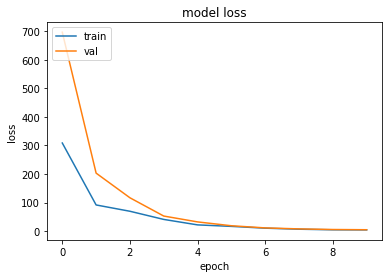

In [70]:
# Plotting the loss-epoch curve 
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_curve.png',bbox_inches='tight')
plt.show()

# Yet to be done

- ## Data Preprocessing
    - ### Class Imbalance Handling
        - Oversampling: Even if instead of 1 model, 3 models were developed for predicting ***neck***, ***sleeve_length*** and ***pattern***, with this severe imbalance in data any synthetic augmentation wouldn't help
        - Undersampling: Undersampling the minority class would help if the problem was being solved using 3 models instead of 1
        - Class Weight: Another alternative for undersampling was assigning weights to the classes during training (higher weights for minoritu classes)

- ## Neural Network Modeling
    - More Training: Due to limited time and limited compute, the model was trained only for 10 epochs. It can be trained for longer after handling the class imbalance
    - Fine-tuning Resnet layer: Another thing I would try was to tune the last few layers of Resnet backbone before the weights flow into our custom model built on top
    - Refine Architecture: The 3 branch of the model as seen in the image can be customized independently to yield better performance
    - AlexNet trained on Fashion-MNIST data: I could have used AlexNet weights trained on Fashion-MNIST data instead of Resnet-50 to do tranfer learning as the Fashion-MNIST data resembles the training data